In [4]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.8 MB/s eta 0:00:00


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from datetime import datetime
import re
import plotly.express as px
import pycountry

In [6]:
# Load the dataset by the same file path upload in the files on this notebook
df = pd.read_csv('/content/ai_job_dataset.csv')

In [7]:
# dataset overview
print("Dataset shape:", df.shape)
print("\nColumn Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Dataset shape: (15000, 19)

Column Types:
 job_id                     object
job_title                  object
salary_usd                  int64
salary_currency            object
experience_level           object
employment_type            object
company_location           object
company_size               object
employee_residence         object
remote_ratio                int64
required_skills            object
education_required         object
years_experience            int64
industry                   object
posting_date               object
application_deadline       object
job_description_length      int64
benefits_score            float64
company_name               object
dtype: object

Missing Values:
 job_id                    0
job_title                 0
salary_usd                0
salary_currency           0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0

/tmp/ipython-input-8-3934042356.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(skills), palette='plasma')


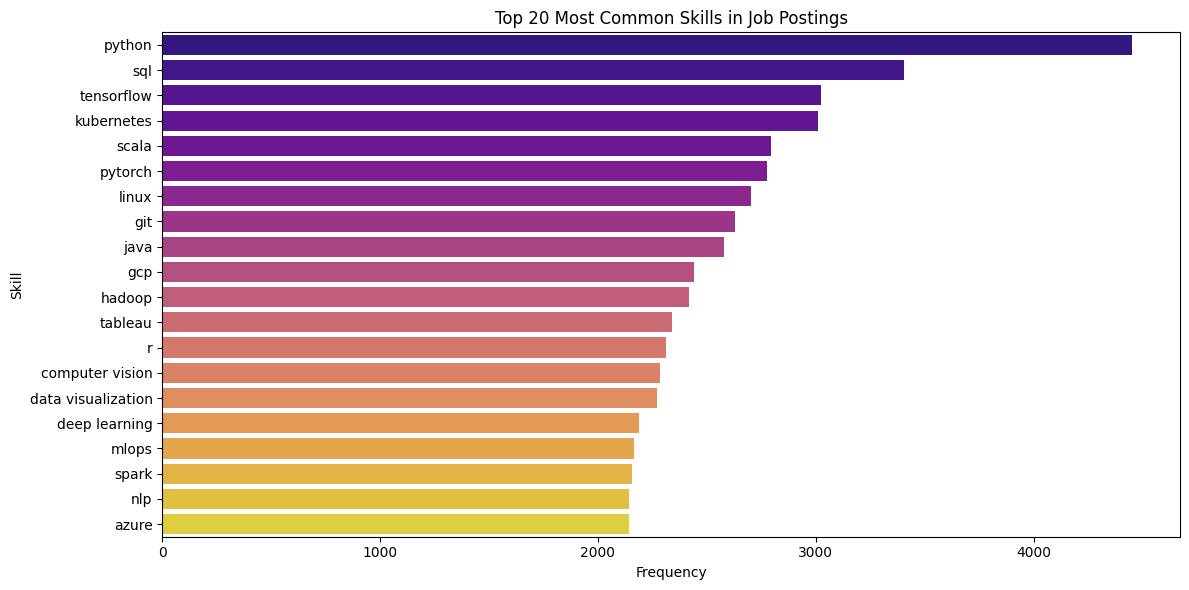

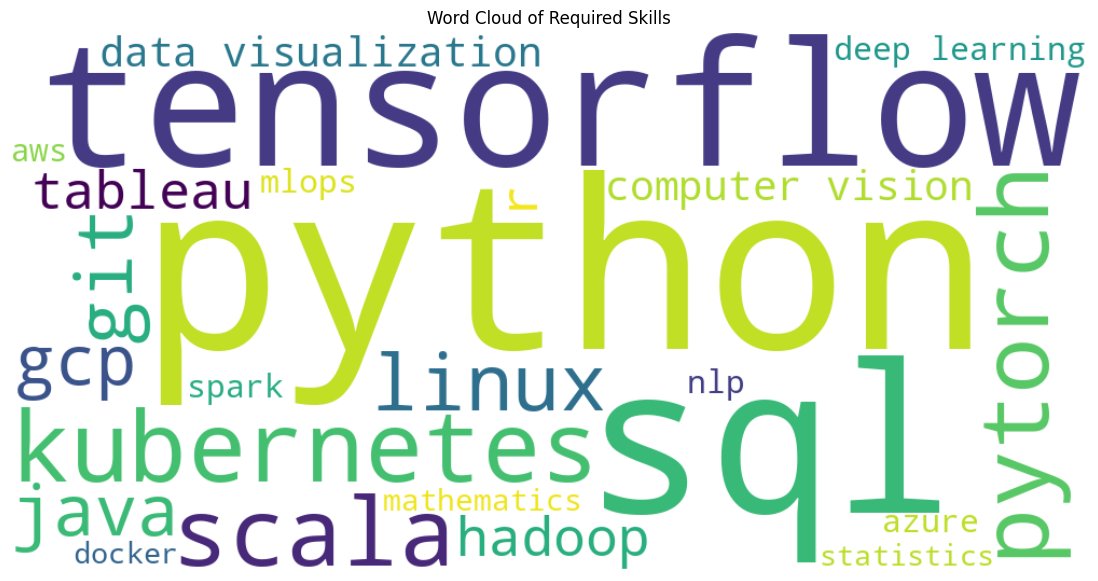

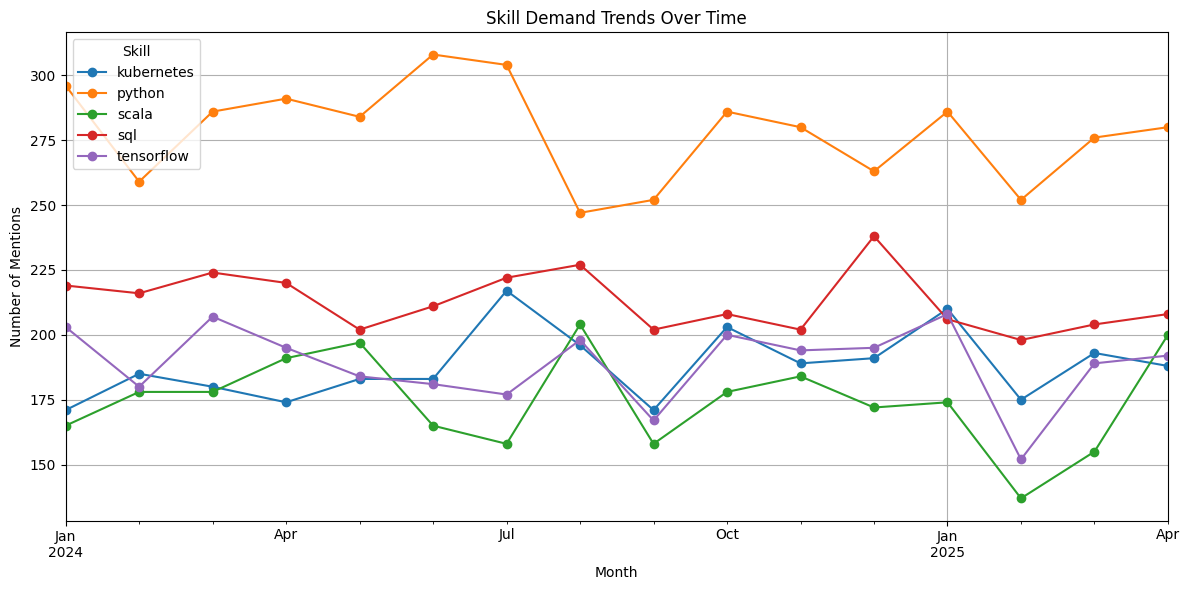

In [8]:
# ----------------------------
# 1. Clean & Tokenize required_skills
# ----------------------------

# Fill NaNs
df['required_skills'] = df['required_skills'].fillna('')

# Use regex to clean each skill list and split into tokens
def extract_skills(skill_str):
    # Remove unwanted characters, normalize spacing
    cleaned = re.sub(r'[^\w,\s]', '', skill_str)  # Remove special chars
    return [skill.strip().lower() for skill in cleaned.split(',') if skill.strip()]

df['skill_list'] = df['required_skills'].apply(extract_skills)

# ----------------------------
# 2. Count Frequency of All Skills
# ----------------------------
all_skills = [skill for skills in df['skill_list'] for skill in skills]
skill_freq = Counter(all_skills)
top_skills = skill_freq.most_common(20)

# ----------------------------
# 3. Bar Chart: Top 20 Most Common Skills
# ----------------------------
skills, counts = zip(*top_skills)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(skills), palette='plasma')
plt.title("Top 20 Most Common Skills in Job Postings")
plt.xlabel("Frequency")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()

# ----------------------------
# 4. Word Cloud of All Skills
# ----------------------------
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(skill_freq)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Required Skills")
plt.show()

# ----------------------------
# 5. Skill Trends Over Time (Optional if you have multiple months)
# ----------------------------

# Convert posting_date to datetime if not already
df['posting_date'] = pd.to_datetime(df['posting_date'])
df['month'] = df['posting_date'].dt.to_period('M')

# Explode skills by row
df_exploded = df.explode('skill_list')

# Group and count skills per month
monthly_skill_counts = df_exploded.groupby(['month', 'skill_list']).size().reset_index(name='count')

# Select a few top skills to visualize trend (e.g., top 5 from previous list)
top_5_skills = [skill for skill, _ in top_skills[:5]]
trend_data = monthly_skill_counts[monthly_skill_counts['skill_list'].isin(top_5_skills)]

# Pivot for trend plotting
trend_pivot = trend_data.pivot(index='month', columns='skill_list', values='count').fillna(0)

# Plot trend
trend_pivot.plot(figsize=(12, 6), marker='o')
plt.title("Skill Demand Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Mentions")
plt.legend(title="Skill")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# ----------------------------
# 1. Convert Dates
# ----------------------------
import pandas as pd # Import pandas if not already imported in this cell

# Load the dataset if df is not defined (e.g., if running this cell independently)
try:
    df['posting_date']
except NameError:
    df = pd.read_csv('/content/ai_job_dataset.csv')


df['posting_date'] = pd.to_datetime(df['posting_date'])
df['application_deadline'] = pd.to_datetime(df['application_deadline'])
df['month'] = df['posting_date'].dt.to_period('M').astype(str)

# ----------------------------
# 2. Interactive Job Posting Trend Over Time
# ----------------------------
monthly_postings = df.groupby('month').size().reset_index(name='job_count')

import plotly.express as px
import plotly.graph_objects as go # Import plotly.graph_objects

fig1 = px.line(
    monthly_postings,
    x='month',
    y='job_count',
    markers=True,
    title='📅 Monthly Job Posting Trend',
    labels={'month': 'Month', 'job_count': 'Number of Postings'},
)
fig1.update_layout(template="plotly_white")
fig1.show()

# ----------------------------
# 3. Extract & Clean Skills
# ----------------------------
df['required_skills'] = df['required_skills'].fillna('')
df['skill_list'] = df['required_skills'].apply(lambda x: [s.strip().lower() for s in x.split(',') if s.strip()])
df_exploded = df.explode('skill_list')

# ----------------------------
# 4. Track Specific Skills (customize this list)
# ----------------------------
tracked_skills = ['python', 'sql', 'docker', 'aws', 'mlops', 'nlp', 'azure', 'tableau', 'linux', 'kubernetes']

# Filter to tracked skills
filtered_df = df_exploded[df_exploded['skill_list'].isin(tracked_skills)]

# Group by month and skill
monthly_skill_counts = (
    filtered_df.groupby(['month', 'skill_list'])
    .size()
    .reset_index(name='count')
)

# ----------------------------
# 5. Interactive Line Chart: Skill Demand Over Time
# ----------------------------
fig2 = px.line(
    monthly_skill_counts,
    x='month',
    y='count',
    color='skill_list',
    markers=True,
    title='📈 Skill Demand Trends Over Time',
    labels={'month': 'Month', 'count': 'Mentions in Job Posts', 'skill_list': 'Skill'}
)
fig2.update_layout(template="plotly_white")
fig2.show()

# ----------------------------
# 6. Interactive Heatmap (Optional)
# ----------------------------
import numpy as np

# 1. Pivot the data for heatmap
heatmap_data = monthly_skill_counts.pivot(index='skill_list', columns='month', values='count').fillna(0)

# 2. Reorder skills by total demand (row sum)
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]

# 3. Create annotated text (optional)
annotations = []
z_text = heatmap_data.values.astype(int)

for n, row in enumerate(z_text):
    for m, val in enumerate(row):
        annotations.append(
            dict(
                text=str(val),
                x=heatmap_data.columns[m],
                y=heatmap_data.index[n],
                xref='x1',
                yref='y1',
                showarrow=False,
                font=dict(color='black' if val < z_text.max()/2 else 'white')
            )
        )

# 4. Create Heatmap
fig3 = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='YlGnBu',
    hoverongaps=False,
    zmin=0,
    zmax=heatmap_data.values.max(),  # Ensures full contrast
    colorbar=dict(title='Job Mentions')
))

# 5. Update layout
fig3.update_layout(
    title='🔥 Skill Frequency Heatmap by Month',
    xaxis_title='Month',
    yaxis_title='Skill',
    annotations=annotations,
    template='plotly_white',
    height=600
)

fig3.show()

In [10]:
# ----------------------------
# Optional Filters
# ----------------------------
# You can activate filtering by un-commenting lines
# df = df[df['experience_level'] == 'SE']           # Filter by experience level
# df = df[df['salary_usd'] > 100000]                # Filter high-paying jobs

# ----------------------------
# Clean and Explode Skills
# ----------------------------
df['required_skills'] = df['required_skills'].fillna('')
df['skill_list'] = df['required_skills'].apply(lambda x: [s.strip().lower() for s in x.split(',') if s.strip()])
df_exploded = df.explode('skill_list')

# ----------------------------
# 1. Top 10 Job Titles Hiring the Most (Interactive)
# ----------------------------
top_jobs = df['job_title'].value_counts().head(10).reset_index()
top_jobs.columns = ['job_title', 'count']

fig1 = px.bar(
    top_jobs,
    x='count',
    y='job_title',
    orientation='h',
    title='🏆 Top 10 Job Titles Hiring the Most',
    labels={'count': 'Number of Postings', 'job_title': 'Job Title'},
    color='count',
    color_continuous_scale='Viridis'
)
fig1.update_layout(template="plotly_white", yaxis={'categoryorder': 'total ascending'})
fig1.show()

# ----------------------------
# 2. Stacked Bar: Skill Distribution by Job Title (Normalized)
# ----------------------------

# Filter to top job titles only
df_top_jobs = df_exploded[df_exploded['job_title'].isin(top_jobs['job_title'])]

# Group and count
skill_counts_by_title = df_top_jobs.groupby(['job_title', 'skill_list']).size().reset_index(name='count')

# Normalize by total counts per job_title (get % share)
total_per_title = skill_counts_by_title.groupby('job_title')['count'].transform('sum')
skill_counts_by_title['percentage'] = (skill_counts_by_title['count'] / total_per_title) * 100

# Filter top skills globally
top_skills = df_exploded['skill_list'].value_counts().head(5).index.tolist()
skill_counts_by_title = skill_counts_by_title[skill_counts_by_title['skill_list'].isin(top_skills)]

# Pivot to stacked format
pivot_df = skill_counts_by_title.pivot(index='job_title', columns='skill_list', values='percentage').fillna(0)

# Build interactive stacked bar
fig2 = go.Figure()

for skill in pivot_df.columns:
    fig2.add_trace(go.Bar(
        name=skill,
        x=pivot_df.index,
        y=pivot_df[skill],
        hovertemplate='%{y:.1f}%',
    ))

fig2.update_layout(
    barmode='stack',
    title='🧠 Normalized Skill Distribution Across Top Job Titles',
    xaxis_title='Job Title',
    yaxis_title='Percentage of Skill Mentions',
    template='plotly_white'
)
fig2.show()

# ----------------------------
# 3. Industries with Most Diverse Skill Sets (Interactive)
# ----------------------------
# 1. Count unique skills per industry
industry_skill_sets = df_exploded.groupby('industry')['skill_list'].apply(lambda x: set(x))
industry_diversity = industry_skill_sets.apply(len).reset_index(name='unique_skill_count')

# 2. Count job posts per industry
industry_job_counts = df.groupby('industry').size().reset_index(name='job_count')

# 3. Calculate average skills per job per industry
industry_avg_skills = df_exploded.groupby('industry').size().reset_index(name='total_skills')
industry_avg_skills = industry_avg_skills.merge(industry_job_counts, on='industry')
industry_avg_skills['avg_skills_per_job'] = industry_avg_skills['total_skills'] / industry_avg_skills['job_count']

# 4. Merge all metrics
industry_summary = industry_diversity.merge(industry_avg_skills, on='industry')

# 5. Sort and take top 10 by unique_skill_count
top_industries = industry_summary.sort_values(by='unique_skill_count', ascending=False).head(10)

# 6. Plot
import plotly.express as px

fig = px.bar(
    top_industries,
    x='unique_skill_count',
    y='industry',
    orientation='h',
    color='avg_skills_per_job',
    title='🌐 Top Industries by Skill Diversity & Complexity',
    labels={
        'unique_skill_count': 'Unique Skills in Industry',
        'avg_skills_per_job': 'Avg. Skills per Job',
        'industry': 'Industry'
    },
    color_continuous_scale='Cividis',
    hover_data={
        'unique_skill_count': True,
        'avg_skills_per_job': ':.2f',
        'job_count': True
    }
)

fig.update_layout(
    template="plotly_white",
    yaxis={'categoryorder': 'total ascending'},
    height=600
)

fig.show()



In [11]:
print("\n--- Debugging Info: df['experience_level'] before exploding ---")
print(df['experience_level'].value_counts(dropna=False))
print("---------------------\n")


df['required_skills'] = df['required_skills'].fillna('')
df['skill_list'] = df['required_skills'].apply(lambda x: [s.strip().lower() for s in x.split(',') if s.strip()])
df_exploded = df.explode('skill_list')

print("\n--- Debugging Info: df_exploded['experience_level'] before dropna ---")
print(df_exploded['experience_level'].value_counts(dropna=False))
print("---------------------\n")

# ----------------------------
# 2. Top Skills per Experience Level (Console Summary)
# ----------------------------
exp_levels = df_exploded['experience_level'].dropna().unique()
top_skills_by_level = {}

print("Top 5 Skills per Experience Level:")
print("=" * 35)
for level in exp_levels:
    subset = df_exploded[df_exploded['experience_level'] == level]
    skill_counts = subset['skill_list'].value_counts().head(5)
    top_skills_by_level[level] = skill_counts
    print(f"\n{level} (Top 5 skills):")
    print(skill_counts.to_string())

# ----------------------------
# 3. Compare Top 5 Skills Across Levels with Bar Chart
# ----------------------------

# Get top 5 skills overall
top_5_skills = df_exploded['skill_list'].value_counts().head(5).index.tolist()

# Create comparison DataFrame
comparison_data = []

for level in exp_levels:
    level_df = df_exploded[df_exploded['experience_level'] == level]
    skill_counts = level_df['skill_list'].value_counts()
    total = skill_counts.sum()

    for skill in top_5_skills:
        freq = skill_counts.get(skill, 0)
        percent = (freq / total * 100) if total else 0
        comparison_data.append({
            'Experience Level': level,
            'Skill': skill,
            'Frequency (%)': round(percent, 2),
            'Count': freq
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n--- Debugging Info ---")
print("exp_levels:", exp_levels)
print("top_5_skills:", top_5_skills)
print("comparison_data (first 10 rows):", comparison_data[:10])
print("comparison_df shape:", comparison_df.shape)
print("comparison_df columns:", comparison_df.columns)
print("---------------------\n")

# Plot grouped bar chart
fig = px.bar(
    comparison_df,
    x='Skill',
    y='Frequency (%)',
    color='Experience Level',
    barmode='group',
    text='Frequency (%)',
    title="📊 Top 10 Skills by Experience Level (Grouped Bar Chart)"
)

fig.update_layout(
    xaxis_title="Skill",
    yaxis_title="Percentage of Mentions",
    xaxis_tickangle=-45,
    template="plotly_white"
)

fig.show()


--- Debugging Info: df['experience_level'] before exploding ---
experience_level
MI    3781
EX    3760
SE    3741
EN    3718
Name: count, dtype: int64
---------------------


--- Debugging Info: df_exploded['experience_level'] before dropna ---
experience_level
MI    15116
SE    14953
EX    14948
EN    14876
Name: count, dtype: int64
---------------------

Top 5 Skills per Experience Level:

SE (Top 5 skills):
skill_list
python        1086
sql            880
tensorflow     783
kubernetes     766
scala          697

EN (Top 5 skills):
skill_list
python        1151
sql            850
kubernetes     743
tensorflow     730
pytorch        703

MI (Top 5 skills):
skill_list
python        1121
sql            858
tensorflow     761
kubernetes     751
pytorch        695

EX (Top 5 skills):
skill_list
python        1092
sql            819
kubernetes     749
tensorflow     748
scala          715

--- Debugging Info ---
exp_levels: ['SE' 'EN' 'MI' 'EX']
top_5_skills: ['python', 'sql', 'tensorflow

In [12]:
# ----------------------------
# Clean and Extract Skills
# ----------------------------
df['required_skills'] = df['required_skills'].fillna('')
df['skill_list'] = df['required_skills'].apply(lambda x: [s.strip().lower() for s in x.split(',') if s.strip()])
df_exploded = df.explode('skill_list')

# ----------------------------
# 1. Salary Distribution by Top Skill (Box Plot)
# ----------------------------
# Focus on top N skills globally
top_skills = df_exploded['skill_list'].value_counts().head(5).index.tolist()
df_salary = df_exploded[df_exploded['skill_list'].isin(top_skills)]

fig1 = px.box(
    df_salary,
    x='skill_list',
    y='salary_usd',
    points='all',
    title='💰 Salary Distribution by Top Skills',
    labels={'skill_list': 'Skill', 'salary_usd': 'Salary (USD)'},
    color='skill_list'
)
fig1.update_layout(template="plotly_white")
fig1.show()


# ----------------------------
# 2. Remote vs On-Site by Skill (Pie Charts)
# ----------------------------
# Classify remote ratio
def remote_category(ratio):
    if ratio == 0:
        return 'On-site'
    elif ratio == 100:
        return 'Remote'
    else:
        return 'Hybrid'

df_exploded['remote_type'] = df_exploded['remote_ratio'].apply(remote_category)

# Create pie charts for top 3 skills
for skill in top_skills[:3]:
    subset = df_exploded[df_exploded['skill_list'] == skill]
    remote_counts = subset['remote_type'].value_counts().reset_index()
    remote_counts.columns = ['remote_type', 'count']

    fig = px.pie(
        remote_counts,
        names='remote_type',
        values='count',
        title=f'🏠 Remote Work Type for "{skill.title()}" Skill',
        color_discrete_sequence=px.colors.sequential.RdBu
    )
    fig.update_traces(textinfo='percent+label')
    fig.update_layout(template="plotly_white")
    fig.show()

# ----------------------------
# 3. Skill Frequency by Company Size (Histogram)
# ----------------------------
df_company = df_exploded[df_exploded['skill_list'].isin(top_skills)]

fig3 = px.histogram(
    df_company,
    x='company_size',
    color='skill_list',
    barmode='group',
    title='🏢 Skill Frequency by Company Size',
    labels={'company_size': 'Company Size', 'count': 'Skill Count'},
    category_orders={'company_size': ['S', 'M', 'L']},
    text_auto=True
)
fig3.update_layout(template="plotly_white")
fig3.show()


# ----------------------------
# 4. Overall Remote Work Distribution
# ----------------------------
overall_remote_counts = df_exploded['remote_type'].value_counts().reset_index()
overall_remote_counts.columns = ['remote_type', 'count']

fig4 = px.pie(
    overall_remote_counts,
    names='remote_type',
    values='count',
    title='🌍 Overall Distribution: Remote vs Hybrid vs On-site Jobs',
    color_discrete_sequence=px.colors.sequential.Blues
)
fig4.update_traces(textinfo='percent+label')
fig4.update_layout(template="plotly_white")
fig4.show()

# ----------------------------
# 5. Company Size Distribution
# ----------------------------
company_size_counts = df['company_size'].value_counts().reset_index()
company_size_counts.columns = ['company_size', 'count']

fig5 = px.pie(
    company_size_counts,
    names='company_size',
    values='count',
    title='🏢 Overall Company Size Distribution',
    color_discrete_sequence=px.colors.sequential.Viridis
)
fig5.update_traces(textinfo='percent+label')
fig5.update_layout(template="plotly_white")
fig5.show()


In [13]:
# ----------------------------
# 1. Prepare Country-Level Skill Count
# ----------------------------
# We'll focus on top 5 skills globally
top_skills = df_exploded['skill_list'].value_counts().head(5).index.tolist()
df_top_skills = df_exploded[df_exploded['skill_list'].isin(top_skills)]

# Count skills per country
country_skill_counts = df_top_skills.groupby(['employee_residence', 'skill_list']).size().reset_index(name='count')

# Normalize country names to ISO alpha-3 for Plotly
def get_alpha3(country_name):
    try:
        return pycountry.countries.search_fuzzy(country_name)[0].alpha_3
    except:
        return None

country_skill_counts['iso_alpha'] = country_skill_counts['employee_residence'].apply(get_alpha3)
country_skill_counts = country_skill_counts.dropna(subset=['iso_alpha'])

# ----------------------------
# 2. Plot Choropleth Maps by Skill
# ----------------------------
for skill in top_skills:
    skill_df = country_skill_counts[country_skill_counts['skill_list'] == skill]

    fig = px.choropleth(
        skill_df,
        locations="iso_alpha",
        color="count",
        hover_name="employee_residence",
        color_continuous_scale="YlOrRd",
        title=f"🌍 Global Demand for '{skill.title()}' Skill",
        labels={'count': 'Mentions in Job Posts'}
    )

    fig.update_layout(template="plotly_white", geo=dict(showframe=False))
    fig.show()

/tmp/ipython-input-14-3849956419.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-14-3849956419.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-14-3849956419.py:41: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



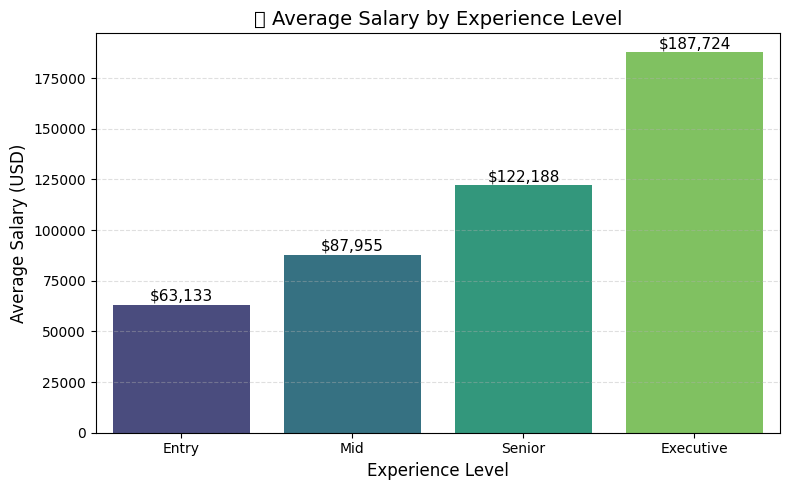

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------
# Step 1: Order & Label Experience Levels
# ----------------------------------
experience_order = ['EN', 'MI', 'SE', 'EX']
experience_labels = ['Entry', 'Mid', 'Senior', 'Executive']

df['experience_label'] = pd.Categorical(
    df['experience_level'],
    categories=experience_order,
    ordered=True
).rename_categories(experience_labels)

# ----------------------------------
# Step 2: Group by Experience and Calculate Average Salary
# ----------------------------------
avg_salary = df.groupby('experience_label')['salary_usd'].mean().reset_index()

# Round for clean labels
avg_salary['salary_usd'] = avg_salary['salary_usd'].round(0)

# ----------------------------------
# Step 3: Plot as Bar Chart
# ----------------------------------
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_salary, x='experience_label', y='salary_usd', palette='viridis')

# Add value labels on top of each bar
for index, row in avg_salary.iterrows():
    plt.text(index, row.salary_usd + 2000, f"${int(row.salary_usd):,}", ha='center', fontsize=11)

# ----------------------------------
# Step 4: Style & Explain
# ----------------------------------
plt.title('📈 Average Salary by Experience Level', fontsize=14)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Average Salary (USD)', fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


/tmp/ipython-input-15-180935818.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-15-180935818.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-15-180935818.py:42: UserWarning:

Glyph 127891 (\N{GRADUATION CAP}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127891 (\N{GRADUATION CAP}) missing from font(s) DejaVu Sans.



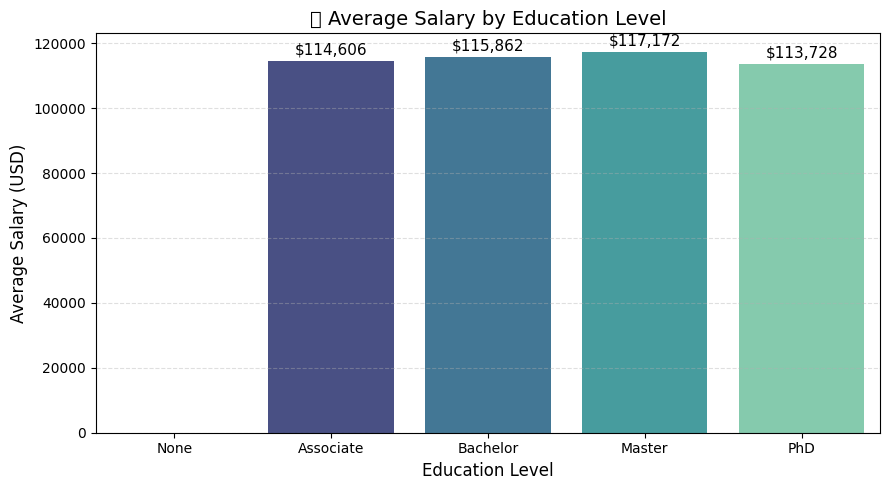

In [15]:

# ----------------------------------
# Step 1: Clean and order education levels
# ----------------------------------

# Define order from lowest to highest level of education
education_order = ['None', 'Associate', 'Bachelor', 'Master', 'PhD']

# Convert to ordered categorical column
df['education_required'] = pd.Categorical(
    df['education_required'],
    categories=education_order,
    ordered=True
)

# ----------------------------------
# Step 2: Group by education level and calculate average salary
# ----------------------------------
edu_salary = df.groupby('education_required')['salary_usd'].mean().reset_index()
edu_salary['salary_usd'] = edu_salary['salary_usd'].round(0)

# Drop rows with NaN in salary_usd before plotting
edu_salary = edu_salary.dropna(subset=['salary_usd'])


# ----------------------------------
# Step 3: Plot bar chart
# ----------------------------------
plt.figure(figsize=(9, 5))
sns.barplot(data=edu_salary, x='education_required', y='salary_usd', palette='mako')

# Add salary labels on bars
for index, row in edu_salary.iterrows():
    plt.text(index, row.salary_usd + 2000, f"${int(row.salary_usd):,}", ha='center', fontsize=11)

# ----------------------------------
# Step 4: Style the plot
# ----------------------------------
plt.title('🎓 Average Salary by Education Level', fontsize=14)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Average Salary (USD)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

/tmp/ipython-input-16-816889038.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-16-816889038.py:39: UserWarning:

Glyph 128187 (\N{PERSONAL COMPUTER}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128187 (\N{PERSONAL COMPUTER}) missing from font(s) DejaVu Sans.



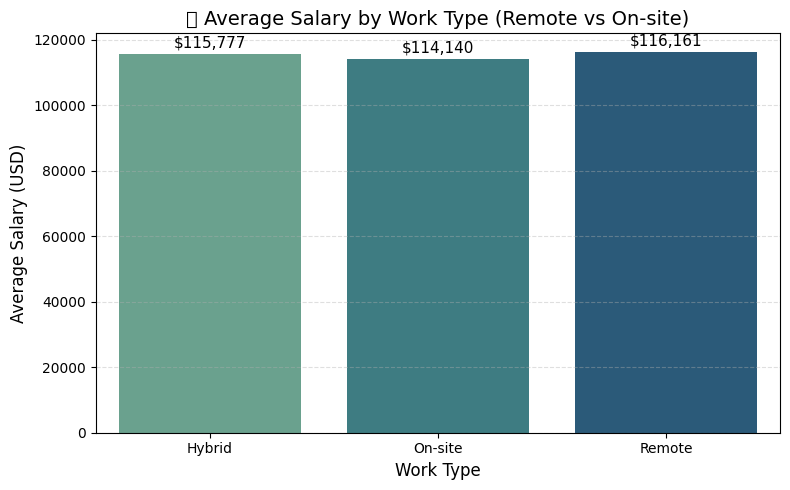

In [16]:
# ----------------------------------
# Step 1: Categorize remote_ratio into 3 groups
# ----------------------------------
def categorize_remote(ratio):
    if ratio == 0:
        return 'On-site'
    elif ratio == 50:
        return 'Hybrid'
    elif ratio == 100:
        return 'Remote'
    else:
        return 'Other'

df['remote_type'] = df['remote_ratio'].apply(categorize_remote)

# ----------------------------------
# Step 2: Group by remote_type and calculate average salary
# ----------------------------------
remote_salary = df.groupby('remote_type')['salary_usd'].mean().reset_index()
remote_salary['salary_usd'] = remote_salary['salary_usd'].round(0)

# ----------------------------------
# Step 3: Plot bar chart
# ----------------------------------
plt.figure(figsize=(8, 5))
sns.barplot(data=remote_salary, x='remote_type', y='salary_usd', palette='crest')

# Add salary value labels
for index, row in remote_salary.iterrows():
    plt.text(index, row.salary_usd + 2000, f"${int(row.salary_usd):,}", ha='center', fontsize=11)

# ----------------------------------
# Step 4: Style the plot
# ----------------------------------
plt.title('💻 Average Salary by Work Type (Remote vs On-site)', fontsize=14)
plt.xlabel('Work Type', fontsize=12)
plt.ylabel('Average Salary (USD)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
